# Loading Datasets

In [2]:
import pandas as pd
import numpy as np

# loading datasets
df = pd.read_csv("../data/raw/2022_US_Region_Mobility_Report.csv")
df_cases = pd.read_csv("../data/raw/Weekly_United_States_COVID-19_Cases_and_Deaths_by_State.csv")

# basic dataset info
df.info()
df_cases.info()

In [ ]:
df

In [ ]:
df_cases

#### Initial Basic Cleaning

In [ ]:
# 1) mobility reports
# necessary columns (country, date, mobility percentages)
mobility_columns = ['retail_and_recreation_percent_change_from_baseline',
    'grocery_and_pharmacy_percent_change_from_baseline',
    'parks_percent_change_from_baseline',
    'transit_stations_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'residential_percent_change_from_baseline']

# converting 'date' column to actual datetime values
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14688 entries, 288 to 742705
Data columns (total 15 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   country_region_code                                 14688 non-null  object        
 1   country_region                                      14688 non-null  object        
 2   sub_region_1                                        14688 non-null  object        
 3   sub_region_2                                        0 non-null      object        
 4   metro_area                                          0 non-null      float64       
 5   iso_3166_2_code                                     14688 non-null  object        
 6   census_fips_code                                    288 non-null    float64       
 7   place_id                                            14688 non-null  object        
 8   date    

#### Initial Basic Data Analysis

In [15]:
# analysis of missing values across the US
rows_before = len(df)
df_clean = df.dropna(subset=mobility_columns, how='any')
rows_after = len(df_clean)

print("Entries before dropping missing values:", rows_before)
print("Entries after dropping missing values:", rows_after)
print("Data loss after dropping missing values:", (round(((rows_before - rows_after)/rows_before*100), 2)),"%")

# analysis of the geographical coverage after cleaning
unique_fips_before = df['census_fips_code'].nunique()
unique_fips_after = df_clean['census_fips_code'].nunique()

print(f"\nUnique FIPS codes before drop: {unique_fips_before}")
print(f"Unique FIPS codes after drop: {unique_fips_after}")
print("FIPS data loss after dropping missing values:", (round(((unique_fips_before - unique_fips_after)/unique_fips_before*100), 2)), "%")

# !!! significant data loss, changing the approach !!!

Entries before dropping missing values: 747969
Entries after dropping missing values: 147224
Data loss after dropping missing values: 80.32 %

Unique FIPS codes before drop: 2810
Unique FIPS codes after drop: 655
FIPS data loss after dropping missing values: 76.69 %


In [ ]:
# next approach: aggregating state-level entries to join with cases and deaths reports
df_mobility = df[(df['sub_region_1'].notnull()) & (df['sub_region_2'].isnull())].copy()

# imputing missing values in mobility data
for col in mobility_columns:
    df_mobility[col] = df_mobility.groupby('sub_region_1')[col].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))

# Dataset Preparation

#### Cleanup & transformations

In [ ]:
# DATASET JOINING STAGE
# cleaning error data and non-numeric strings
cleaning_columns = ['tot_cases', 'new_cases', 'tot_deaths', 'new_deaths', 'new_historic_cases', 'new_historic_deaths']

for column in cleaning_columns:
    df_cases[column] = df_cases[column].astype(str).str.replace(',', '').astype(float)

# date conversion and column rename
df_cases['end_date'] = pd.to_datetime(df_cases['end_date'])
df_cases.rename(columns={'end_date': 'date', 'state': 'state_code'}, inplace=True)

# filtering for data relevant to 2022 and unnecessary columns clean up
df_cases = df_cases[(df_cases['date'].dt.year == 2022)].copy()
df_cases = df_cases[['date', 'state_code', 'new_cases', 'new_deaths']]
df_cases.dropna(subset=['new_cases'], inplace=True)

# mapping state names
# state name/code mapping dictionary for all possible states
state_name_to_code = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN',
    'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR',
    'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA',
    'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY',
}

# mapping state names
df_mobility['state_code'] = df_mobility['sub_region_1'].map(state_name_to_code)

#### Joining Datasets

In [ ]:
df_joined = pd.merge(
    df_mobility,
    df_cases,
    on=['date', 'state_code'],
    how='left'
)
# forward fill the weekly case count to all daily records in that week
df_joined['new_cases_weekly'] = df_joined.groupby('state_code')['new_cases'].ffill()

# checking the join outcomes
df_joined.info()

# Exploratory Data Analysis

#### Statistical Summary

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

summary = df_joined[mobility_columns].describe().T
print(summary)

                                                      count       mean  \
retail_and_recreation_percent_change_from_baseline  14716.0  -5.762028   
grocery_and_pharmacy_percent_change_from_baseline   14716.0   0.362666   
parks_percent_change_from_baseline                  14673.0  63.490561   
transit_stations_percent_change_from_baseline       14716.0  -6.861172   
workplaces_percent_change_from_baseline             14716.0 -19.812789   
residential_percent_change_from_baseline            14716.0   4.076787   

                                                          std   min   25%  \
retail_and_recreation_percent_change_from_baseline  12.106231 -94.0 -12.0   
grocery_and_pharmacy_percent_change_from_baseline   10.857472 -91.0  -6.0   
parks_percent_change_from_baseline                  80.401571 -67.0   0.0   
transit_stations_percent_change_from_baseline       23.601001 -91.0 -23.0   
workplaces_percent_change_from_baseline             11.147609 -80.0 -26.0   
residential_percent

#### Correlation Matrix

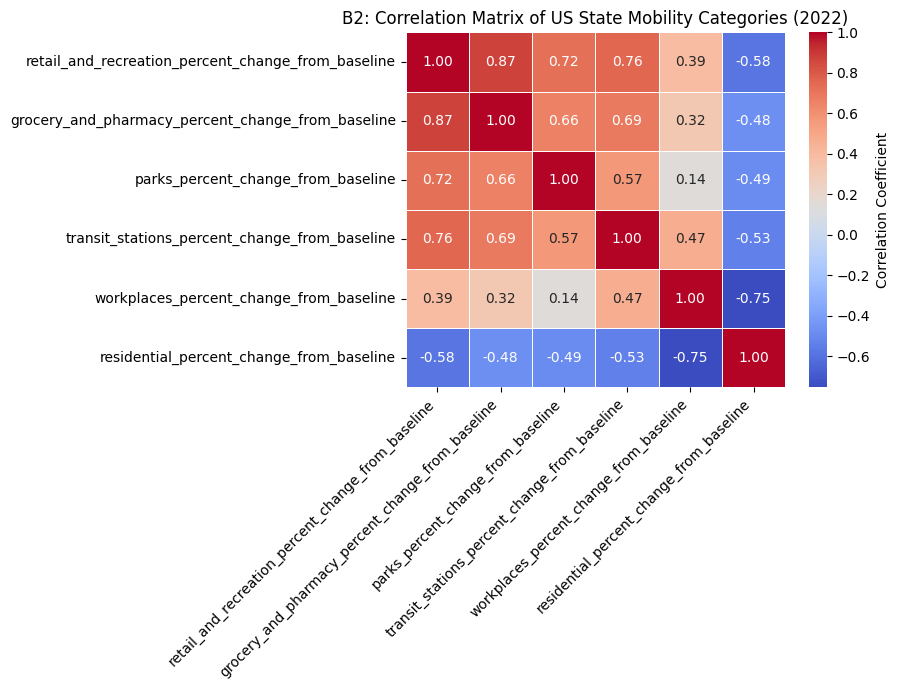

In [37]:
correlation_matrix = df_joined[mobility_columns].corr()
# heatmap visualization
plt.figure(figsize=(9, 7))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('B2: Correlation Matrix of US State Mobility Categories (2022)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

#### Time Series Graphs

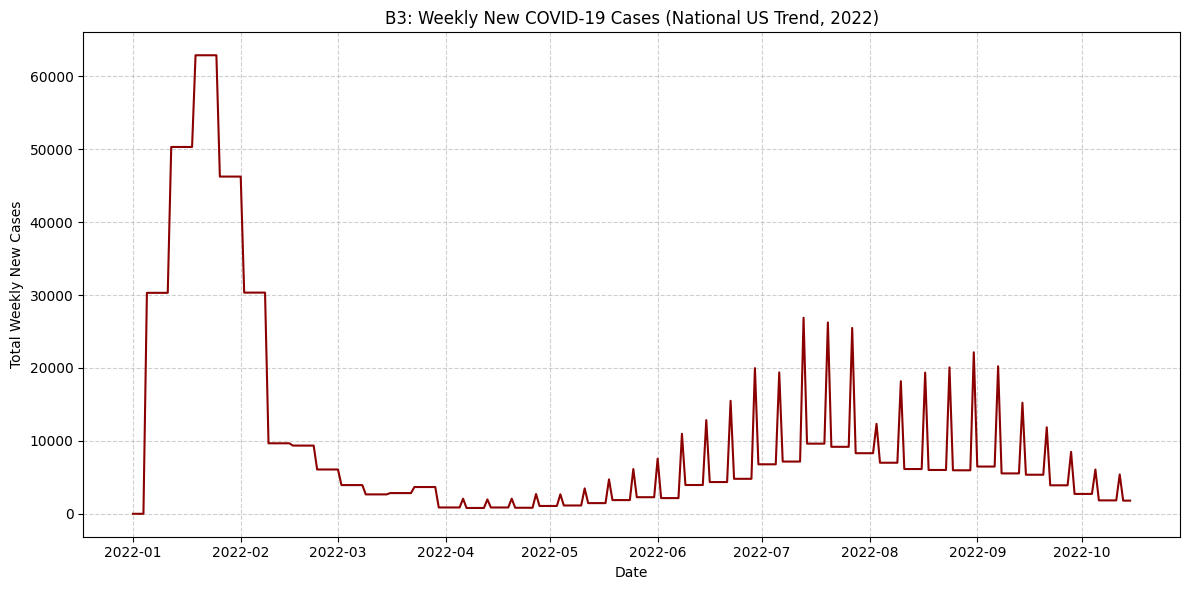

In [39]:
# aggregating plotting weekly cases by date
df_ts_plot = df_joined.groupby('date')['new_cases_weekly'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_ts_plot, x='date', y='new_cases_weekly', color='darkred')
plt.title('B3: Weekly New COVID-19 Cases (National US Trend, 2022)')
plt.xlabel('Date')
plt.ylabel('Total Weekly New Cases')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Models Training

# Models Evaluation